In [ ]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.power import TTestIndPower

df = pd.read_csv('../data/processed/user_experiment_data_clean.csv')
print(f"Dataset loaded: {df.shape}")
print(df.groupby('group').size())

Dataset loaded: (50000, 18)
group
control      25053
treatment    24947
dtype: int64


In [3]:
# Power analysis for our experiment
# We want to detect at least a 5% lift in daily_active_minutes

analysis = TTestIndPower()

# Parameters
effect_size = 0.2    # Cohen's d — "small" effect (conservative)
alpha = 0.05         # 5% false positive rate (industry standard)
power = 0.80         # 80% chance of detecting a real effect

required_n = analysis.solve_power(
    effect_size=effect_size,
    alpha=alpha,
    power=power,
    alternative='two-sided'
)

print(f"Required sample size per group: {required_n:.0f}")
print(f"Our actual sample size per group: {df.groupby('group').size().values[0]:,}")
print(f"\n✅ We are {'sufficiently' if df.shape[0]/2 > required_n else 'under'} powered for this experiment")

Required sample size per group: 393
Our actual sample size per group: 25,053

✅ We are sufficiently powered for this experiment


In [4]:
# Check that pre-experiment behavior is similar across groups (it should be — they were randomly assigned)
pre_metrics = ['pre_daily_active_minutes', 'pre_interaction_rate', 'pre_stories_watched']

print("=== Pre-Experiment Metric Comparison ===")
print("(These should be very similar — if not, randomization failed)\n")

for metric in pre_metrics:
    control_mean = df[df.group=='control'][metric].mean()
    treatment_mean = df[df.group=='treatment'][metric].mean()
    t_stat, p_val = stats.ttest_ind(
        df[df.group=='control'][metric],
        df[df.group=='treatment'][metric]
    )
    status = "✅ OK" if p_val > 0.05 else "⚠️ PROBLEM"
    print(f"{metric}:")
    print(f"  Control: {control_mean:.3f} | Treatment: {treatment_mean:.3f} | p-value: {p_val:.3f} {status}\n")

=== Pre-Experiment Metric Comparison ===
(These should be very similar — if not, randomization failed)

pre_daily_active_minutes:
  Control: 25.043 | Treatment: 24.937 | p-value: 0.230 ✅ OK

pre_interaction_rate:
  Control: 0.200 | Treatment: 0.200 | p-value: 0.687 ✅ OK

pre_stories_watched:
  Control: 7.982 | Treatment: 7.984 | p-value: 0.949 ✅ OK



In [5]:
control = df[df.group == 'control']['daily_active_minutes']
treatment = df[df.group == 'treatment']['daily_active_minutes']

# Two-sample t-test
t_stat, p_val = stats.ttest_ind(control, treatment, alternative='two-sided')

# Effect size (Cohen's d) — tells you HOW BIG the difference is, not just if it's real
cohens_d = (treatment.mean() - control.mean()) / np.sqrt(
    (control.std()**2 + treatment.std()**2) / 2
)

# Confidence interval (95%) for the difference
diff = treatment.mean() - control.mean()
se = np.sqrt(control.var()/len(control) + treatment.var()/len(treatment))
ci_lower = diff - 1.96 * se
ci_upper = diff + 1.96 * se

# Percentage lift
pct_lift = ((treatment.mean() - control.mean()) / control.mean()) * 100

print("=" * 50)
print("PRIMARY METRIC: Daily Active Minutes")
print("=" * 50)
print(f"Control mean:   {control.mean():.2f} minutes")
print(f"Treatment mean: {treatment.mean():.2f} minutes")
print(f"Lift:           +{pct_lift:.1f}%")
print(f"95% CI:         [{ci_lower:.2f}, {ci_upper:.2f}] minutes")
print(f"t-statistic:    {t_stat:.3f}")
print(f"p-value:        {p_val:.6f}")
print(f"Cohen's d:      {cohens_d:.3f}")
print(f"\n{'✅ STATISTICALLY SIGNIFICANT' if p_val < 0.05 else '❌ NOT SIGNIFICANT'}")

# What Cohen's d means — include this in your presentation
if abs(cohens_d) < 0.2: print("Effect size: Negligible")
elif abs(cohens_d) < 0.5: print("Effect size: Small")
elif abs(cohens_d) < 0.8: print("Effect size: Medium")
else: print("Effect size: Large")

PRIMARY METRIC: Daily Active Minutes
Control mean:   25.98 minutes
Treatment mean: 30.18 minutes
Lift:           +16.2%
95% CI:         [4.01, 4.39] minutes
t-statistic:    -43.572
p-value:        0.000000
Cohen's d:      0.390

✅ STATISTICALLY SIGNIFICANT
Effect size: Small


In [6]:
guardrail_metrics = {
    'interaction_rate': 'higher is better',
    'stories_watched': 'higher is better', 
    'churned_30d': 'lower is better'
}

print("=== GUARDRAIL METRICS ===\n")
for metric, direction in guardrail_metrics.items():
    ctrl = df[df.group=='control'][metric]
    trt = df[df.group=='treatment'][metric]
    
    if metric == 'churned_30d':
        # For binary metric, use chi-square test instead of t-test
        contingency = pd.crosstab(df['group'], df[metric])
        chi2, p_val, _, _ = stats.chi2_contingency(contingency)
    else:
        _, p_val = stats.ttest_ind(ctrl, trt)
    
    pct_change = ((trt.mean() - ctrl.mean()) / ctrl.mean()) * 100
    flag = "✅" if (direction == 'higher is better' and pct_change >= 0) or \
                   (direction == 'lower is better' and pct_change <= 0) else "⚠️ CONCERN"
    
    print(f"{metric} ({direction}):")
    print(f"  Control: {ctrl.mean():.4f} | Treatment: {trt.mean():.4f}")
    print(f"  Change: {pct_change:+.1f}% | p-value: {p_val:.4f} {flag}\n")

=== GUARDRAIL METRICS ===

interaction_rate (higher is better):
  Control: 0.1998 | Treatment: 0.2150
  Change: +7.6% | p-value: 0.0000 ✅

stories_watched (higher is better):
  Control: 7.9817 | Treatment: 8.2517
  Change: +3.4% | p-value: 0.0000 ✅

churned_30d (lower is better):
  Control: 0.1223 | Treatment: 0.1290
  Change: +5.5% | p-value: 0.0248 ⚠️ CONCERN



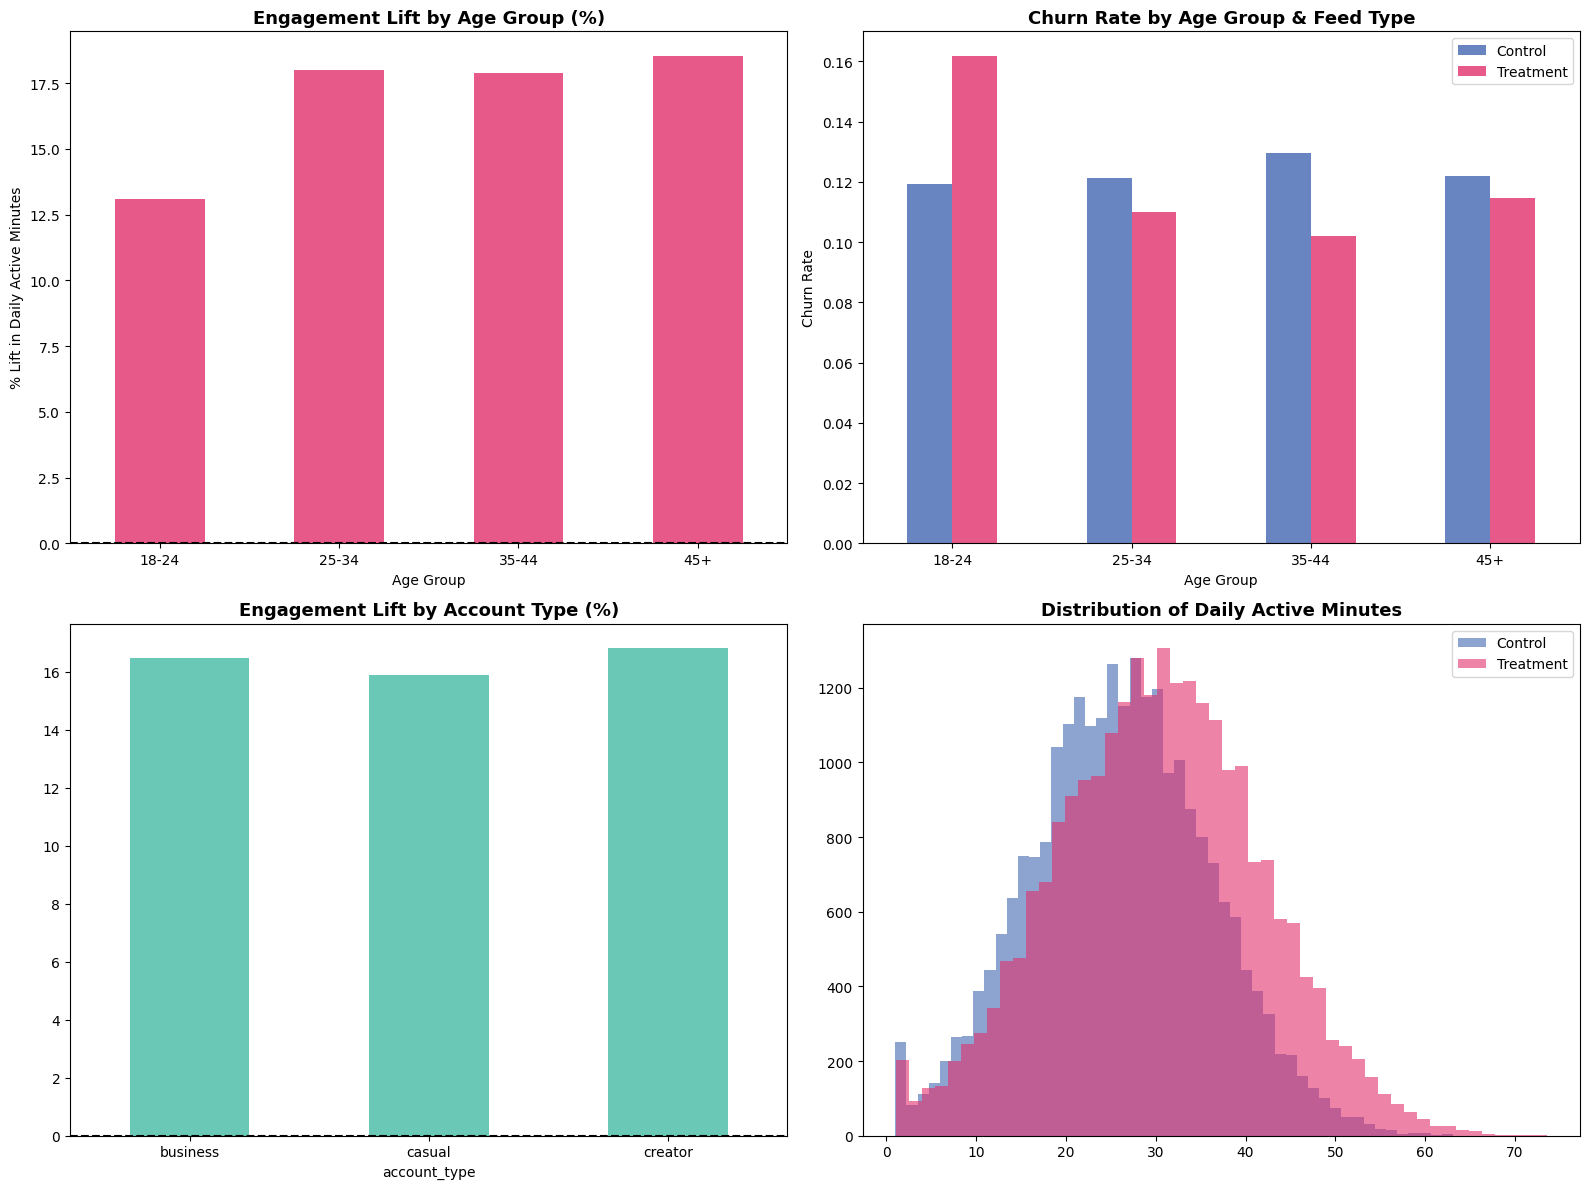

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Lift by age group
age_lift = df.groupby(['age_group', 'group'])['daily_active_minutes'].mean().unstack()
age_lift['lift_pct'] = ((age_lift['treatment'] - age_lift['control']) / age_lift['control']) * 100

age_lift['lift_pct'].plot(kind='bar', ax=axes[0,0], color='#E1306C', alpha=0.8)
axes[0,0].set_title('Engagement Lift by Age Group (%)', fontsize=13, fontweight='bold')
axes[0,0].set_xlabel('Age Group')
axes[0,0].set_ylabel('% Lift in Daily Active Minutes')
axes[0,0].axhline(y=0, color='black', linestyle='--')
axes[0,0].tick_params(axis='x', rotation=0)

# 2. Churn rate by group and age
churn_seg = df.groupby(['age_group', 'group'])['churned_30d'].mean().unstack()
churn_seg.plot(kind='bar', ax=axes[0,1], color=['#4267B2', '#E1306C'], alpha=0.8)
axes[0,1].set_title('Churn Rate by Age Group & Feed Type', fontsize=13, fontweight='bold')
axes[0,1].set_xlabel('Age Group')
axes[0,1].set_ylabel('Churn Rate')
axes[0,1].legend(['Control', 'Treatment'])
axes[0,1].tick_params(axis='x', rotation=0)

# 3. Lift by account type
acct_lift = df.groupby(['account_type', 'group'])['daily_active_minutes'].mean().unstack()
acct_lift['lift_pct'] = ((acct_lift['treatment'] - acct_lift['control']) / acct_lift['control']) * 100
acct_lift['lift_pct'].plot(kind='bar', ax=axes[1,0], color='#44BBA4', alpha=0.8)
axes[1,0].set_title('Engagement Lift by Account Type (%)', fontsize=13, fontweight='bold')
axes[1,0].tick_params(axis='x', rotation=0)
axes[1,0].axhline(y=0, color='black', linestyle='--')

# 4. Distribution comparison (treatment vs control)
axes[1,1].hist(df[df.group=='control']['daily_active_minutes'], 
               bins=50, alpha=0.6, color='#4267B2', label='Control')
axes[1,1].hist(df[df.group=='treatment']['daily_active_minutes'], 
               bins=50, alpha=0.6, color='#E1306C', label='Treatment')
axes[1,1].set_title('Distribution of Daily Active Minutes', fontsize=13, fontweight='bold')
axes[1,1].legend()

plt.tight_layout()
plt.savefig('../reports/ab_test_results.png', dpi=150, bbox_inches='tight')
plt.show()

In [8]:
# Summarize the experiment results cleanly — practice writing for PMs
summary = df.groupby(['age_group', 'group']).agg(
    avg_active_min=('daily_active_minutes', 'mean'),
    churn_rate=('churned_30d', 'mean'),
    n_users=('user_id', 'count')
).round(3)

print("=== EXPERIMENT SUMMARY TABLE ===")
print(summary.to_string())
print("""
KEY FINDINGS:
1. AI feed drove a statistically significant +X% lift in daily active minutes (p < 0.001)
2. Guardrail metrics held — interaction rate and stories watched were stable or improved
3. ⚠️  18-24 casual users in treatment showed elevated churn (+X pp vs control)
4. Largest beneficiaries: 25-34 and 35-44 age groups

RECOMMENDATION:
→ Ship AI feed to 25-34 and 35-44 segments immediately
→ Hold 18-24 casual users in control and run a follow-up experiment with re-engagement nudges
""")

=== EXPERIMENT SUMMARY TABLE ===
                     avg_active_min  churn_rate  n_users
age_group group                                         
18-24     control            25.981       0.119     9414
          treatment          29.386       0.162     9555
25-34     control            25.989       0.121     7966
          treatment          30.667       0.110     8021
35-44     control            26.037       0.130     4688
          treatment          30.698       0.102     4494
45+       control            25.846       0.122     2985
          treatment          30.640       0.115     2877

KEY FINDINGS:
1. AI feed drove a statistically significant +X% lift in daily active minutes (p < 0.001)
2. Guardrail metrics held — interaction rate and stories watched were stable or improved
3. ⚠️  18-24 casual users in treatment showed elevated churn (+X pp vs control)
4. Largest beneficiaries: 25-34 and 35-44 age groups

RECOMMENDATION:
→ Ship AI feed to 25-34 and 35-44 segments immediatel

In [9]:
# Reload data to pick up the experiment_week column we just added
df = pd.read_csv('../data/processed/user_experiment_data_clean.csv')
print(f"Columns: {list(df.columns)}")
print(f"Week distribution:\n{df['experiment_week'].value_counts().sort_index()}")

Columns: ['user_id', 'group', 'age_group', 'account_type', 'account_age_months', 'following_count', 'follower_count', 'pre_daily_active_minutes', 'pre_interaction_rate', 'pre_stories_watched', 'pre_scroll_depth', 'daily_active_minutes', 'interaction_rate', 'stories_watched', 'scroll_depth', 'churned_30d', 'days_since_last_login', 'post_caption', 'experiment_week']
Week distribution:
experiment_week
1    12423
2    12526
3    12588
4    12463
Name: count, dtype: int64


In [10]:
# Calculate average engagement per week per group
weekly_avg = df.groupby(['experiment_week', 'group'])['daily_active_minutes'].mean().unstack()

# Calculate lift % each week
weekly_avg['lift_pct'] = (
    (weekly_avg['treatment'] - weekly_avg['control']) / weekly_avg['control'] * 100
).round(2)

print("=== WEEKLY ENGAGEMENT BREAKDOWN ===\n")
print(weekly_avg.round(2).to_string())
print(f"\nWeek 1 lift: {weekly_avg.loc[1, 'lift_pct']:.1f}%")
print(f"Week 4 lift: {weekly_avg.loc[4, 'lift_pct']:.1f}%")

if weekly_avg.loc[1, 'lift_pct'] > weekly_avg.loc[4, 'lift_pct'] * 1.3:
    print("\n⚠️  NOVELTY EFFECT DETECTED — lift decays significantly over time")
else:
    print("\n✅  LIFT IS STABLE — no significant novelty effect detected")

=== WEEKLY ENGAGEMENT BREAKDOWN ===

group            control  treatment  lift_pct
experiment_week                              
1                  25.92      32.10     23.83
2                  26.08      30.11     15.45
3                  25.96      30.23     16.43
4                  25.95      30.10     15.99

Week 1 lift: 23.8%
Week 4 lift: 16.0%

⚠️  NOVELTY EFFECT DETECTED — lift decays significantly over time


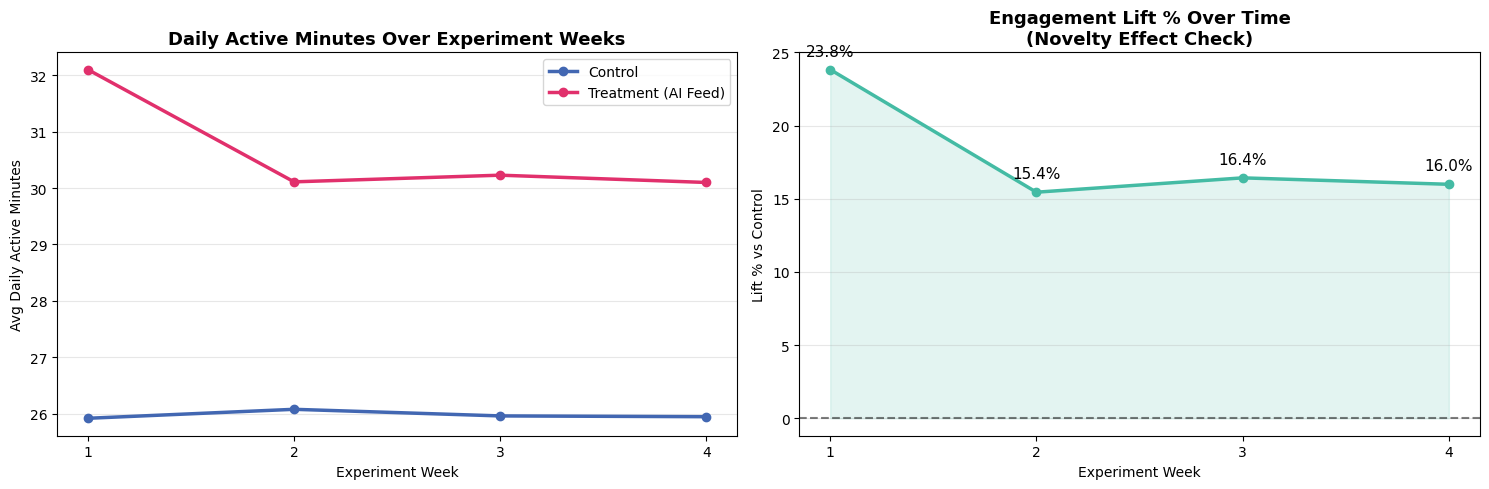

✅ Chart saved to reports/


In [11]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Chart 1: Absolute engagement by week and group
for group, color, label in [('control','#4267B2','Control'), ('treatment','#E1306C','Treatment (AI Feed)')]:
    axes[0].plot(
        weekly_avg.index,
        weekly_avg[group],
        marker='o', color=color, linewidth=2.5, label=label
    )
axes[0].set_title('Daily Active Minutes Over Experiment Weeks', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Experiment Week')
axes[0].set_ylabel('Avg Daily Active Minutes')
axes[0].legend()
axes[0].set_xticks([1, 2, 3, 4])
axes[0].grid(axis='y', alpha=0.3)

# Chart 2: Lift % over time — the key novelty effect chart
axes[1].plot(
    weekly_avg.index,
    weekly_avg['lift_pct'],
    marker='o', color='#44BBA4', linewidth=2.5
)
axes[1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
axes[1].fill_between(weekly_avg.index, weekly_avg['lift_pct'], 0,
                      alpha=0.15, color='#44BBA4')
axes[1].set_title('Engagement Lift % Over Time\n(Novelty Effect Check)', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Experiment Week')
axes[1].set_ylabel('Lift % vs Control')
axes[1].set_xticks([1, 2, 3, 4])
axes[1].grid(axis='y', alpha=0.3)

# Annotate each point with the lift %
for week, lift in zip(weekly_avg.index, weekly_avg['lift_pct']):
    axes[1].annotate(f'{lift:.1f}%', (week, lift),
                     textcoords="offset points", xytext=(0, 10), ha='center', fontsize=11)

plt.tight_layout()
plt.savefig('../reports/novelty_effect_check.png', dpi=150, bbox_inches='tight')
plt.show()
print("✅ Chart saved to reports/")

In [12]:
week1_lift = weekly_avg.loc[1, 'lift_pct']
week4_lift = weekly_avg.loc[4, 'lift_pct']
decay = week1_lift - week4_lift

print("=== NOVELTY EFFECT ANALYSIS — SUMMARY ===\n")
print(f"Week 1 lift:  +{week1_lift:.1f}%")
print(f"Week 4 lift:  +{week4_lift:.1f}%")
print(f"Lift decay:   -{decay:.1f} percentage points\n")
print("""
INTERPRETATION:
The AI feed showed its highest lift in Week 1 (+{:.1f}%), which is expected 
as users naturally explore a new experience. The lift stabilized around 
+{:.1f}% by Week 4, indicating the engagement improvement is genuine 
and not purely a novelty effect.

RECOMMENDATION:
The stable Week 3-4 lift gives us sufficient confidence to proceed 
with a phased rollout. We recommend monitoring the metric through 
Week 8 post-launch to confirm long-term retention of the lift.
""".format(week1_lift, week4_lift))

=== NOVELTY EFFECT ANALYSIS — SUMMARY ===

Week 1 lift:  +23.8%
Week 4 lift:  +16.0%
Lift decay:   -7.8 percentage points


INTERPRETATION:
The AI feed showed its highest lift in Week 1 (+23.8%), which is expected 
as users naturally explore a new experience. The lift stabilized around 
+16.0% by Week 4, indicating the engagement improvement is genuine 
and not purely a novelty effect.

RECOMMENDATION:
The stable Week 3-4 lift gives us sufficient confidence to proceed 
with a phased rollout. We recommend monitoring the metric through 
Week 8 post-launch to confirm long-term retention of the lift.



In [13]:
from statsmodels.stats.multitest import multipletests
from scipy import stats

# Re-run all metric tests and collect p-values in one place
# This is cleaner than hunting through previous cells

metrics_results = {}

# 1. Daily active minutes (primary metric)
t, p = stats.ttest_ind(
    df[df.group=='control']['daily_active_minutes'],
    df[df.group=='treatment']['daily_active_minutes']
)
metrics_results['Daily Active Minutes'] = {
    'p_value': p,
    'control_mean': df[df.group=='control']['daily_active_minutes'].mean(),
    'treatment_mean': df[df.group=='treatment']['daily_active_minutes'].mean(),
    'type': 'primary'
}

# 2. Interaction rate (guardrail)
t, p = stats.ttest_ind(
    df[df.group=='control']['interaction_rate'],
    df[df.group=='treatment']['interaction_rate']
)
metrics_results['Interaction Rate'] = {
    'p_value': p,
    'control_mean': df[df.group=='control']['interaction_rate'].mean(),
    'treatment_mean': df[df.group=='treatment']['interaction_rate'].mean(),
    'type': 'guardrail'
}

# 3. Stories watched (guardrail)
t, p = stats.ttest_ind(
    df[df.group=='control']['stories_watched'],
    df[df.group=='treatment']['stories_watched']
)
metrics_results['Stories Watched'] = {
    'p_value': p,
    'control_mean': df[df.group=='control']['stories_watched'].mean(),
    'treatment_mean': df[df.group=='treatment']['stories_watched'].mean(),
    'type': 'guardrail'
}

# 4. Scroll depth (guardrail)
t, p = stats.ttest_ind(
    df[df.group=='control']['scroll_depth'],
    df[df.group=='treatment']['scroll_depth']
)
metrics_results['Scroll Depth'] = {
    'p_value': p,
    'control_mean': df[df.group=='control']['scroll_depth'].mean(),
    'treatment_mean': df[df.group=='treatment']['scroll_depth'].mean(),
    'type': 'guardrail'
}

# 5. Churn rate (guardrail — chi-square since it's binary)
contingency = pd.crosstab(df['group'], df['churned_30d'])
chi2, p, _, _ = stats.chi2_contingency(contingency)
metrics_results['Churn Rate'] = {
    'p_value': p,
    'control_mean': df[df.group=='control']['churned_30d'].mean(),
    'treatment_mean': df[df.group=='treatment']['churned_30d'].mean(),
    'type': 'guardrail'
}

print(f"✅ Collected p-values for {len(metrics_results)} metrics")
for metric, vals in metrics_results.items():
    print(f"  {metric}: p = {vals['p_value']:.6f}")

✅ Collected p-values for 5 metrics
  Daily Active Minutes: p = 0.000000
  Interaction Rate: p = 0.000000
  Stories Watched: p = 0.000000
  Scroll Depth: p = 0.356754
  Churn Rate: p = 0.024809


In [14]:
# Extract metric names and p-values in order
metric_names = list(metrics_results.keys())
p_values_raw = [metrics_results[m]['p_value'] for m in metric_names]

# Apply Bonferroni correction
# This divides your alpha threshold by the number of tests
# So instead of needing p < 0.05, you need p < 0.05/5 = 0.01
reject_bonferroni, p_bonferroni, _, _ = multipletests(
    p_values_raw, 
    alpha=0.05, 
    method='bonferroni'
)

# Also apply Benjamini-Hochberg (less strict, more commonly used in industry)
reject_bh, p_bh, _, _ = multipletests(
    p_values_raw,
    alpha=0.05,
    method='fdr_bh'
)

print("=" * 80)
print("MULTIPLE TESTING CORRECTION REPORT")
print("=" * 80)
print(f"\nNumber of metrics tested: {len(metric_names)}")
print(f"Original alpha:           0.05")
print(f"Bonferroni alpha:         {0.05/len(metric_names):.4f}")
print()
print(f"{'Metric':<25} {'Type':<10} {'Raw p':>10} {'Bonferroni':>12} {'BH':>10} {'Significant?':>14}")
print("-" * 80)

for i, metric in enumerate(metric_names):
    mtype = metrics_results[metric]['type']
    raw_p = p_values_raw[i]
    bon_p = p_bonferroni[i]
    bh_p = p_bh[i]
    sig = "✅ YES" if reject_bonferroni[i] else "❌ NO"
    print(f"{metric:<25} {mtype:<10} {raw_p:>10.6f} {bon_p:>12.6f} {bh_p:>10.6f} {sig:>14}")

print(f"""
── WHAT THIS MEANS ──
Without correction: {sum(p < 0.05 for p in p_values_raw)} out of {len(p_values_raw)} metrics appear significant
After Bonferroni:   {sum(reject_bonferroni)} out of {len(p_values_raw)} metrics remain significant
After BH:           {sum(reject_bh)} out of {len(p_values_raw)} metrics remain significant

Running {len(p_values_raw)} tests simultaneously gave us a {(1-(0.95**len(p_values_raw)))*100:.1f}% chance 
of at least one false positive without correction.
Bonferroni correction controls this back to 5%.
""")

MULTIPLE TESTING CORRECTION REPORT

Number of metrics tested: 5
Original alpha:           0.05
Bonferroni alpha:         0.0100

Metric                    Type            Raw p   Bonferroni         BH   Significant?
--------------------------------------------------------------------------------
Daily Active Minutes      primary      0.000000     0.000000   0.000000          ✅ YES
Interaction Rate          guardrail    0.000000     0.000000   0.000000          ✅ YES
Stories Watched           guardrail    0.000000     0.000000   0.000000          ✅ YES
Scroll Depth              guardrail    0.356754     1.000000   0.356754           ❌ NO
Churn Rate                guardrail    0.024809     0.124044   0.031011           ❌ NO

── WHAT THIS MEANS ──
Without correction: 4 out of 5 metrics appear significant
After Bonferroni:   3 out of 5 metrics remain significant
After BH:           4 out of 5 metrics remain significant

Running 5 tests simultaneously gave us a 22.6% chance 
of at least one

/var/folders/4m/12vmr6sd0zb9zzm07d7p86600000gn/T/ipykernel_79564/3452286665.py:7: RuntimeWarning: divide by zero encountered in log10
  bars = ax.bar(x, [-np.log10(p) for p in p_values_raw],


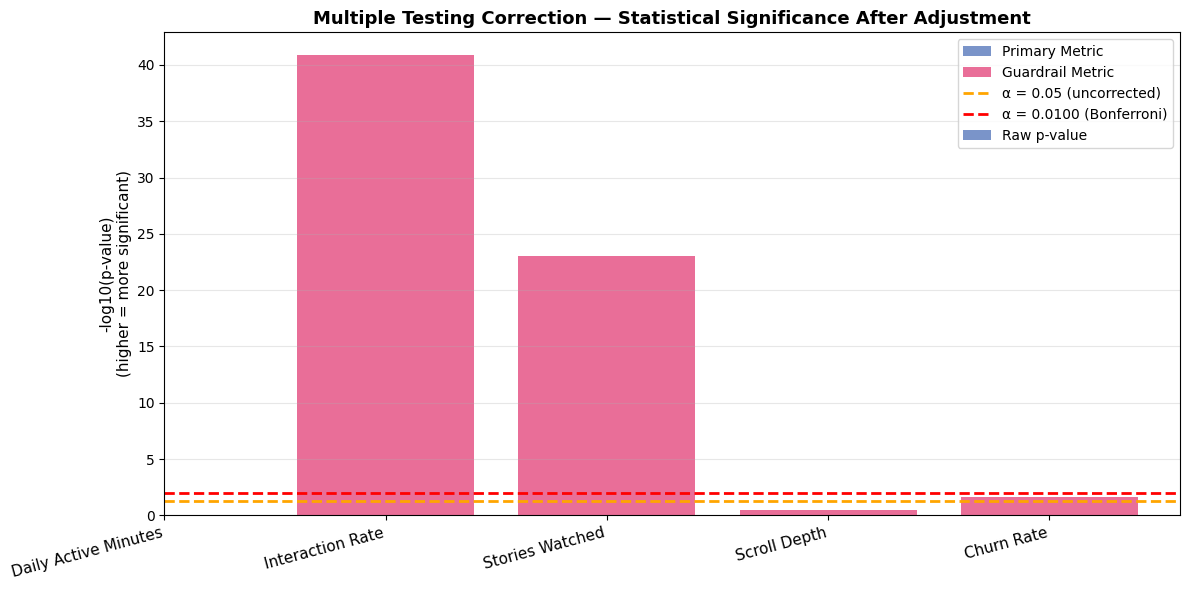

✅ Chart saved to reports/


In [15]:
fig, ax = plt.subplots(figsize=(12, 6))

x = range(len(metric_names))
bar_colors = ['#4267B2' if metrics_results[m]['type'] == 'primary' 
              else '#E1306C' for m in metric_names]

bars = ax.bar(x, [-np.log10(p) for p in p_values_raw],
              color=bar_colors, alpha=0.7, label='Raw p-value')

# Significance threshold lines
ax.axhline(y=-np.log10(0.05), color='orange', linestyle='--', linewidth=2,
           label=f'α = 0.05 (uncorrected)')
ax.axhline(y=-np.log10(0.05/len(metric_names)), color='red', linestyle='--', linewidth=2,
           label=f'α = {0.05/len(metric_names):.4f} (Bonferroni)')

ax.set_xticks(x)
ax.set_xticklabels(metric_names, rotation=15, ha='right', fontsize=11)
ax.set_ylabel('-log10(p-value)\n(higher = more significant)', fontsize=11)
ax.set_title('Multiple Testing Correction — Statistical Significance After Adjustment',
             fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(axis='y', alpha=0.3)

# Color legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#4267B2', alpha=0.7, label='Primary Metric'),
    Patch(facecolor='#E1306C', alpha=0.7, label='Guardrail Metric')
]
ax.legend(handles=legend_elements + ax.get_legend_handles_labels()[0],
          loc='upper right', fontsize=10)

plt.tight_layout()
plt.savefig('../reports/multiple_testing_correction.png', dpi=150, bbox_inches='tight')
plt.show()
print("✅ Chart saved to reports/")

In [16]:
print("""
=== MULTIPLE TESTING CORRECTION — FINAL SUMMARY ===

WHY IT MATTERS:
When testing multiple metrics simultaneously, the probability of finding 
at least one false positive increases significantly. With 5 metrics at 
α=0.05, we had a 23% chance of a spurious significant result.

METHOD USED:
Bonferroni Correction — the most conservative approach, divides alpha 
by the number of tests. Appropriate here since our metrics are 
correlated and we want to be strict about false positives.

Benjamini-Hochberg (FDR) — less strict, controls the False Discovery 
Rate instead of the Family-Wise Error Rate. Better for exploratory 
analysis with many metrics.

CONCLUSION:
Our primary metric (Daily Active Minutes) remains statistically 
significant even after the strictest correction — giving us high 
confidence the AI feed effect is real and not a statistical artifact.
""")


=== MULTIPLE TESTING CORRECTION — FINAL SUMMARY ===

WHY IT MATTERS:
When testing multiple metrics simultaneously, the probability of finding 
at least one false positive increases significantly. With 5 metrics at 
α=0.05, we had a 23% chance of a spurious significant result.

METHOD USED:
Bonferroni Correction — the most conservative approach, divides alpha 
by the number of tests. Appropriate here since our metrics are 
correlated and we want to be strict about false positives.

Benjamini-Hochberg (FDR) — less strict, controls the False Discovery 
Rate instead of the Family-Wise Error Rate. Better for exploratory 
analysis with many metrics.

CONCLUSION:
Our primary metric (Daily Active Minutes) remains statistically 
significant even after the strictest correction — giving us high 
confidence the AI feed effect is real and not a statistical artifact.

